# README
SVM and Feedforward neural networks are tried on the PCA (principal components analysis) dataset, with the PCA fitted from the **expanded** dataset. PCA is loaded in from pickled files to avoid having to retrain.

From the expanded dataset, 4883 components are required for 99.9% variance.

This file shows models not discussed in the paper.

# Setup

In [3]:
!pip install datasets

from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os

In [ ]:
# Stringify a numeric label into textual form
def decode_label(label):
    if label == 1:
        return "rock"
    elif label == 0:
        return "paper"
    elif label == 2:
        return "scissors"
    elif label == 3:
        return "none"
    return None
    # return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image


## PCA Specific

In [ ]:
!gdown 1lDME-_L8RExsmE8r3afNkHP0n_Tk0vTr

Downloading...
From (original): https://drive.google.com/uc?id=1_8iMwpnoGSnVzx_JuAeWXaPuLSt2cX-r
From (redirected): https://drive.google.com/uc?id=1_8iMwpnoGSnVzx_JuAeWXaPuLSt2cX-r&confirm=t&uuid=d45b1d1f-c1f5-4618-8ca9-ebc60bf50be6
To: c:\Users\mkame\CS4262\Project\Image-Recognition-and-Joint-Detection-for-Rock-Paper-Scissors\pca_lowres.pkl

  0%|          | 0.00/640M [00:00<?, ?B/s]
  0%|          | 1.05M/640M [00:00<01:15, 8.45MB/s]
  1%|          | 4.19M/640M [00:00<00:36, 17.5MB/s]
  1%|          | 6.82M/640M [00:00<00:31, 20.0MB/s]
  1%|▏         | 9.44M/640M [00:00<00:29, 21.6MB/s]
  2%|▏         | 12.6M/640M [00:00<00:26, 23.3MB/s]
  2%|▏         | 15.7M/640M [00:00<00:25, 24.4MB/s]
  3%|▎         | 18.4M/640M [00:00<00:25, 24.2MB/s]
  3%|▎         | 21.5M/640M [00:00<00:24, 25.0MB/s]
  4%|▍         | 24.6M/640M [00:01<00:24, 25.5MB/s]
  4%|▍         | 27.8M/640M [00:01<00:23, 26.1MB/s]
  5%|▍         | 30.9M/640M [00:01<00:23, 26.3MB/s]
  5%|▌         | 34.1M/640M [00:01<00:23

In [ ]:
!gdown 1SY2AMlg-kthcXZctlTQjomoJGgEi1gWw
!gdown 1UR2pwrja8IltGh40mBDoRzAQ27AJ1HF3

Downloading...
From: https://drive.google.com/uc?id=1PPB3SHLhhRYoXCqHypOK31Vt8gK9UdrL
To: c:\Users\mkame\CS4262\Project\Image-Recognition-and-Joint-Detection-for-Rock-Paper-Scissors\pca_mean.pkl

  0%|          | 0.00/262k [00:00<?, ?B/s]
100%|██████████| 262k/262k [00:00<00:00, 4.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qs91x9ja1W5R3t4xHpuZSp8xza-mOHxO
To: c:\Users\mkame\CS4262\Project\Image-Recognition-and-Joint-Detection-for-Rock-Paper-Scissors\pca_std_dev.pkl

  0%|          | 0.00/262k [00:00<?, ?B/s]
100%|██████████| 262k/262k [00:00<00:00, 3.56MB/s]


In [4]:
import pickle as pk
with open("pca_lowres.pkl", 'rb') as f:
    pca_4883 = pk.load(f)
with open("pca_mean.pkl", 'rb') as f:
    mean = pk.load(f)
with open("pca_std_dev.pkl", 'rb') as f:
    std_dev = pk.load(f)

C:\Users\mkame\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
def reconstitute(npdata, num_components):
    pca = pca_4883
    val = np.dot(npdata[:num_components], pca.components_[:num_components]) # * std_dev + mean
    # val = val * std_dev + mean
    valn = np.clip(np.round(val * std_dev + mean), 0, 255).astype(np.uint8)
    # print(valn)
    img = toImage(valn.reshape((256, 256, 1)))
    return img


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256), # (32, 256)),

    # transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomInvert(p=1),
    transforms.PILToTensor(),

])

toImage = transforms.Compose([
    transforms.ToPILImage(),
])


In [ ]:
merged_jointly_ds = ds

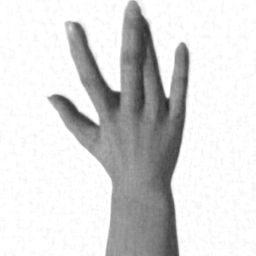

In [ ]:
reconstitute(merged_jointly_ds['train'][0]['pca'], 2000)

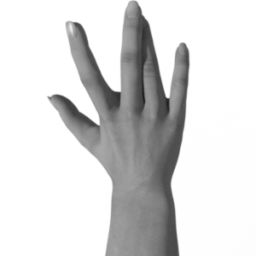

In [ ]:
toImage(transform(merged_jointly_ds['train'][0]['image']))

# SVM

SVM is trained for 4883 components from PCA.

SVM is also trained on positive labels only from the expanded dataset (which would be Base + kaggle)

### All

In [ ]:
labels = np.empty( len(ds['train']) )
labels_test = np.empty( len(ds['test']) )

for i, row in enumerate(ds['train']):
    x = row['label']
    labels[i] = x

for i, row in enumerate(ds['test']):
    labels_test[i] = row['label']


In [ ]:
from itertools import chain


def pca_design_matrix(ds, num_components):

    X = []
    Xtest = []
    # X = np.array((len(ds['train']), num_components))
    # Xtest = np.array((len(ds['test']), num_components))

    for i, row in enumerate(ds['train']):
        X.append(row['pca'][:num_components])


    for i, row in enumerate(ds['test']):
        Xtest.append(row['pca'][:num_components])

    return X, Xtest

In [ ]:
pca_ds = merged_jointly_ds

In [ ]:
import time
start = time.time()

X4883, Xtest4883 = pca_design_matrix(pca_ds, 4883)

end = time.time()
print("Time for 4883:", end - start)

Time for 4883: 132.30801272392273


In [ ]:
X4883np = np.array(X4883)
Xtest4883np = np.array(Xtest4883)
# labels_array =

Accuracy: 0.8496314496314497
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.55      0.61       253
         1.0       0.78      0.56      0.65       270
         2.0       0.69      0.79      0.74       287
         3.0       0.93      0.99      0.96      1225

    accuracy                           0.85      2035
   macro avg       0.77      0.72      0.74      2035
weighted avg       0.84      0.85      0.84      2035



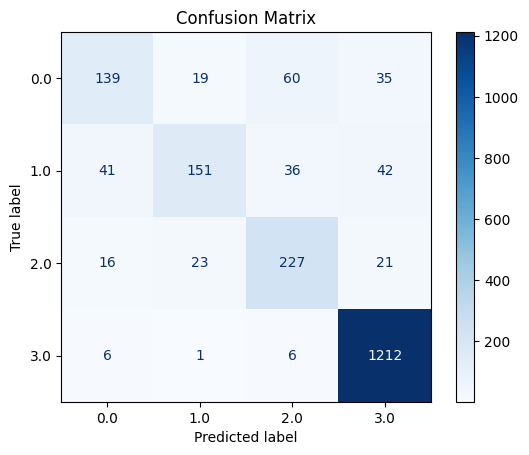

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(X4883np, labels)

# Predict labels for the test set
y_pred = svm_model.predict(Xtest4883np)

# Evaluate the model
print("Accuracy:", accuracy_score(labels_test, y_pred))
print("Classification Report:")
print(classification_report(labels_test, y_pred))

cm = confusion_matrix(labels_test, y_pred, labels=svm_model.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Try only positive labels

In [ ]:
X4883pos = X4883np[labels != 3]
labelspos = labels[labels != 3]

In [ ]:
Xtest4883pos = Xtest4883np[labels_test != 3]
labels_test_pos = labels_test[labels_test != 3]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(X4883pos, labelspos)

Accuracy: 0.682716049382716
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.56      0.60       253
         1.0       0.69      0.68      0.68       270
         2.0       0.70      0.79      0.74       287

    accuracy                           0.68       810
   macro avg       0.68      0.68      0.68       810
weighted avg       0.68      0.68      0.68       810



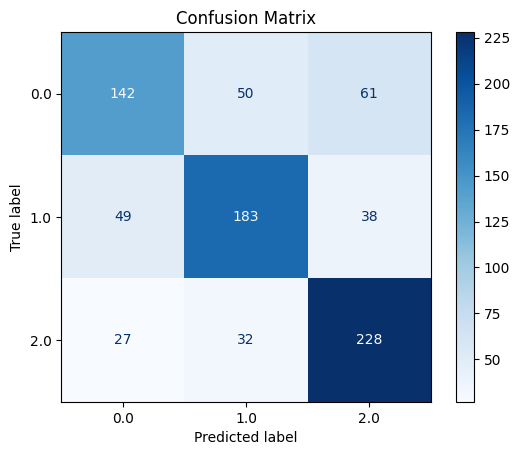

In [ ]:

# Predict labels for the test set
y_pred = svm_model.predict(Xtest4883pos)

# Evaluate the model
print("Accuracy:", accuracy_score(labels_test_pos, y_pred))
print("Classification Report:")
print(classification_report(labels_test_pos, y_pred))

cm = confusion_matrix(labels_test_pos, y_pred, labels=svm_model.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# NN

Neural networks are trained for 4883 components from PCA. It is trained on positive lables only (Base + kaggle)

In [ ]:
X4883np.shape

(9170, 4883)

In [ ]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4883, 1000)  # Input layer
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1000, 1000)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1000, 3)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for the input layer
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))  # No activation function for the output layer
        x = self.drop2(x)
        x = self.fc3(x)
        return x

# Create an instance of the network
net = Net()


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

data = torch.tensor(X4883pos, dtype=torch.float32)
# Create a Dataset
dataset = TensorDataset(data, torch.tensor(labelspos, dtype=torch.uint8))

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# Training loop
for epoch in range(25):  # number of epochs
    for inputs, targets in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print loss for every epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [ ]:
from sklearn.metrics import confusion_matrix

def pca_evaluate_nn():
    # Assuming you have your test data and labels
    # Convert test data and labels to PyTorch tensors
    test_data = torch.tensor(Xtest4883pos, dtype=torch.float32)
    test_labels = torch.tensor(labels_test_pos, dtype=torch.long)

    # Create a Dataset for test data
    test_dataset = TensorDataset(test_data, test_labels)

    # Create a DataLoader for test data
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    # Switch the network to evaluation mode
    net.eval()

    # Initialize the count of correct predictions
    correct = 0
    total = 0

    predicted_labels = []
    true_labels = []

    # No need to track gradients for evaluation
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            # Forward pass
            outputs = net(inputs)

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Update total
            total += targets.size(0)

            # Update correct
            correct += (predicted == targets).sum().item()
            predicted_labels.extend(predicted.numpy())
            true_labels.extend(targets.numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total

    print(f'Accuracy of the network on the test data: {accuracy} %')

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm


Accuracy of the network on the test data: 72.46913580246914 %
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       253
           1       0.71      0.80      0.75       270
           2       0.72      0.79      0.75       287

    accuracy                           0.72       810
   macro avg       0.73      0.72      0.72       810
weighted avg       0.73      0.72      0.72       810



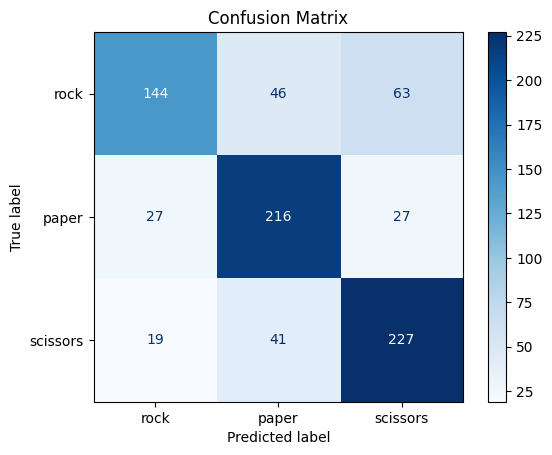

In [ ]:
cm = pca_evaluate_nn()
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rock', 'paper', 'scissors'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()